In [62]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [63]:
path_file= "diabetes_dataset.csv"

In [64]:
columns_to_delete=["ID","No_Pation","Gender"]
label= "CLASS"
correlation_columns=["Cr"]

In [65]:
def create_dataset(path_file):
    df = pd.read_csv(path_file)
    return df

def rescaler(df):
    scaler = MinMaxScaler()
    columns_to_scale = df.columns.difference([label])
    df_scaled_part = pd.DataFrame(scaler.fit_transform(df[columns_to_scale]), columns=columns_to_scale)
    # Riaggiungi la colonna 'class' senza modificarla
    df_scaled = pd.concat([df_scaled_part, df[label]], axis=1)
    # (Opzionale) Riorganizza le colonne per mantenere l'ordine originale
    df_scaled = df_scaled[df.columns]
    return df_scaled

def create_dataframe_features_selected(df:pd.DataFrame,columns:list):
    return df[columns]

def preprocessing(df):
    df=df.drop(columns= columns_to_delete)
    #eliminazione colonna correlata
    df=df.drop(columns=correlation_columns)
    df[label] = df[label].str.replace(' ', '', regex=False)
    # df = create_dataframe_features_selected(df,all_features)
    df=rescaler(df)
    mappa_valori = {'N': 0, 'P': 1, 'Y': 2}
    df[label] = df[label].map(mappa_valori)

    return df

def balance_dataset_labels(df:pd.DataFrame, percent=0.8):
    # Filtra le righe con label 'Y'
    righe_y = df[df[label] == 2]
    # Calcola il numero di righe da rimuovere (30%)
    n_da_rimuovere = int(len(righe_y) * percent)
    # Estrae casualmente le righe da rimuovere
    righe_da_rimuovere = righe_y.sample(n=n_da_rimuovere, random_state=42)
    # Rimuove queste righe dal dataset originale
    df_filtrato = df.drop(righe_da_rimuovere.index)
    return df_filtrato

def visualize_dataset(df):
    print("shape",df.shape)
    print(df.head())


In [66]:
df=create_dataset(path_file)
df=preprocessing(df)
df=balance_dataset_labels(df)
visualize_dataset(df)

shape (325, 10)
        AGE      Urea     HbA1c      Chol        TG       HDL       LDL  \
0  0.508475  0.109375  0.264901  0.407767  0.044444  0.226804  0.114583   
1  0.101695  0.104167  0.264901  0.359223  0.081481  0.092784  0.187500   
2  0.508475  0.109375  0.264901  0.407767  0.044444  0.226804  0.114583   
3  0.508475  0.109375  0.264901  0.407767  0.044444  0.226804  0.114583   
4  0.220339  0.171875  0.264901  0.475728  0.051852  0.061856  0.177083   

       VLDL       BMI  CLASS  
0  0.011461  0.173913      0  
1  0.014327  0.139130      0  
2  0.011461  0.173913      0  
3  0.011461  0.173913      0  
4  0.008596  0.069565      0  


# Visualizziamo il Dataset per coppie di features

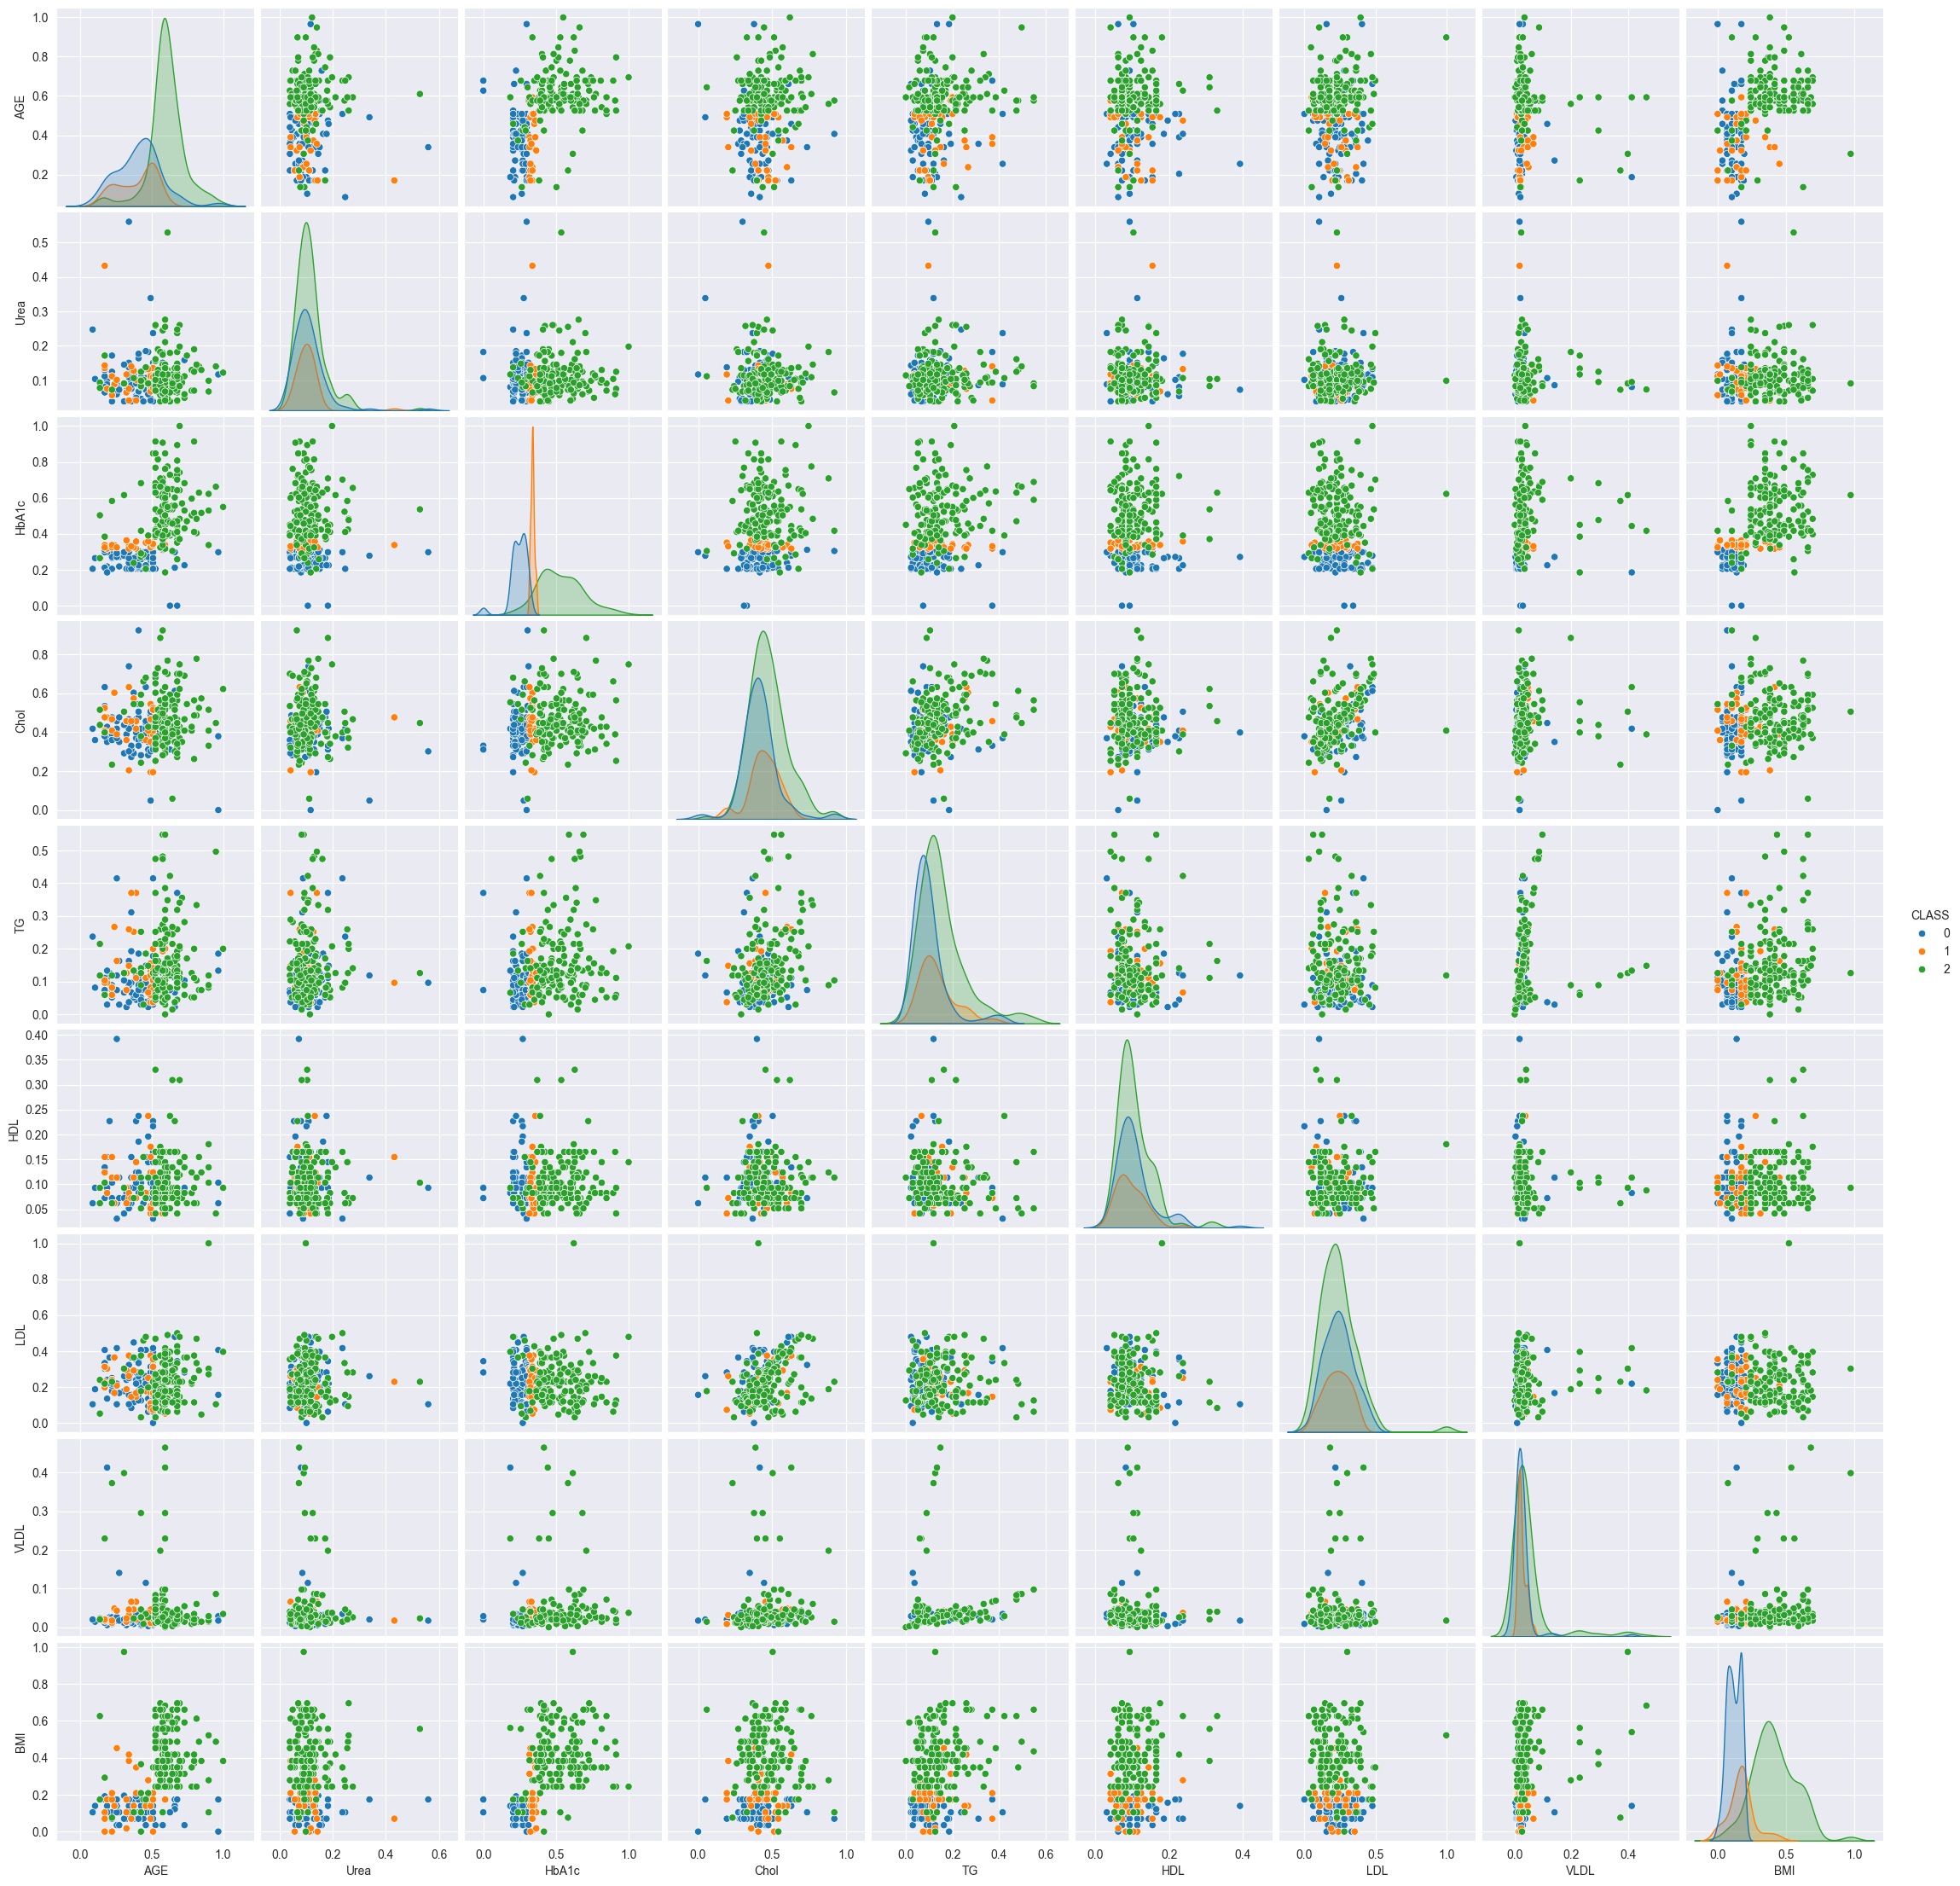

In [67]:
import seaborn as sns
sns.pairplot(df, hue=label, palette="tab10")

### Correlazione

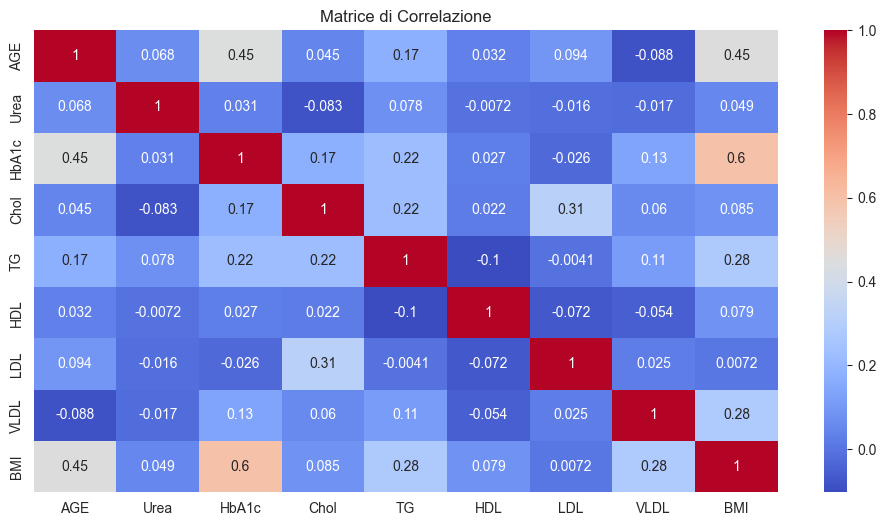

In [68]:
import matplotlib.pyplot as plt

df_corr=df.drop(columns=[label])
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice di Correlazione")
plt.show()

### Features e Label

In [69]:
X = df.drop(label, axis=1)
y = df[label]

### TrainSet e TestSet

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Train (f,l): {len(X_train)}, {len(y_train)}")
print(f"Test (f,l): {len(X_test)}, {len(y_test)}")

Train (f,l): 227, 227
Test (f,l): 98, 98


# Classificatore Classico

In [71]:
dtc=DecisionTreeClassifier(random_state=42)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

# Valutiamo il classificatore

In [72]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred=dtc.predict(X_test)
print(f"test accuracy: {accuracy_score(y_test,y_pred)}")


precision_score= precision_score(y_test, y_pred, average='weighted')  # 'macro', 'micro', 'weighted'
recall_score=recall_score(y_test, y_pred, average='weighted')
f1_score=f1_score(y_test, y_pred, average='weighted')

print(precision_score)
print(recall_score)
print(f1_score)


test accuracy: 0.9795918367346939
0.9807580174927114
0.9795918367346939
0.9796748486628695


# Quantum Variational Classifier

### Circuito per Encoding

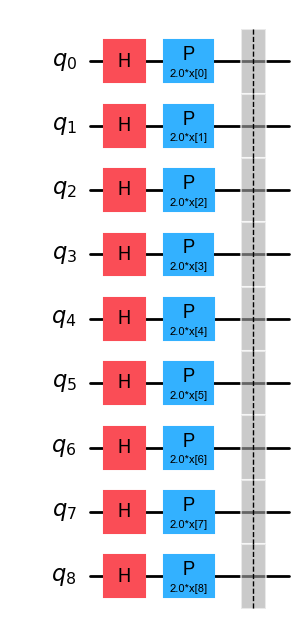

In [73]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap

num_features = df.shape[1]-1

#feature_map = PauliFeatureMap(feature_dimension=num_features, reps=1)
#feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map = ZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.barrier()
feature_map.decompose().draw(output="mpl", fold=20)

In [74]:
X_train_new=X_train.values.tolist()
X_test_new=X_test.values.tolist()
y_train_new=y_train.tolist()
y_test_new=y_test.tolist()

### Quantum Circuit Ansatz

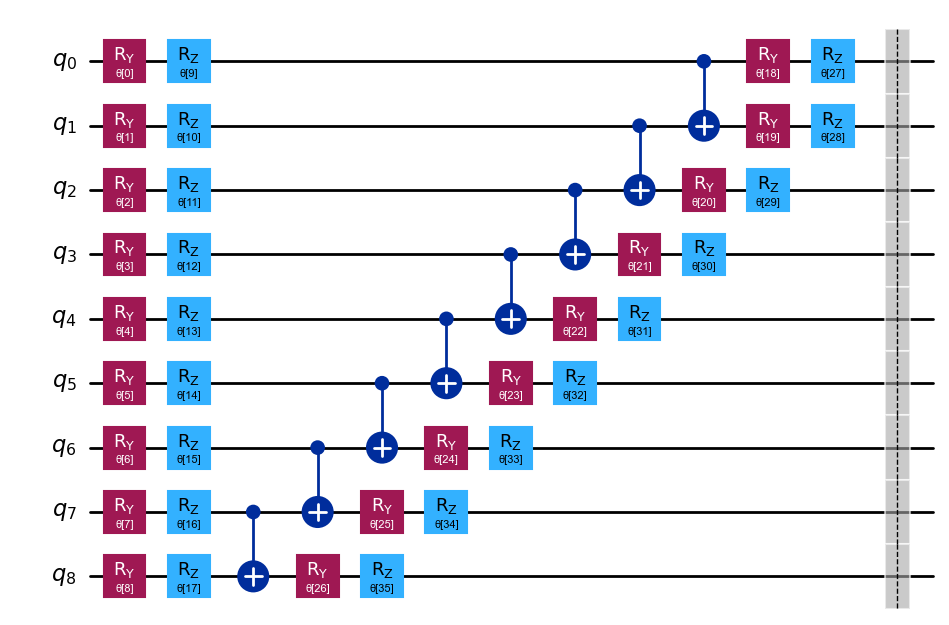

In [75]:
from qiskit.circuit.library import EfficientSU2

ansatz=EfficientSU2(num_features,reps=1)
ansatz.barrier()
ansatz.decompose().draw(output="mpl", fold=20)

## Combiniamo il tutto ed eseguiamo l'algoritmo Variational Quantum Classifier

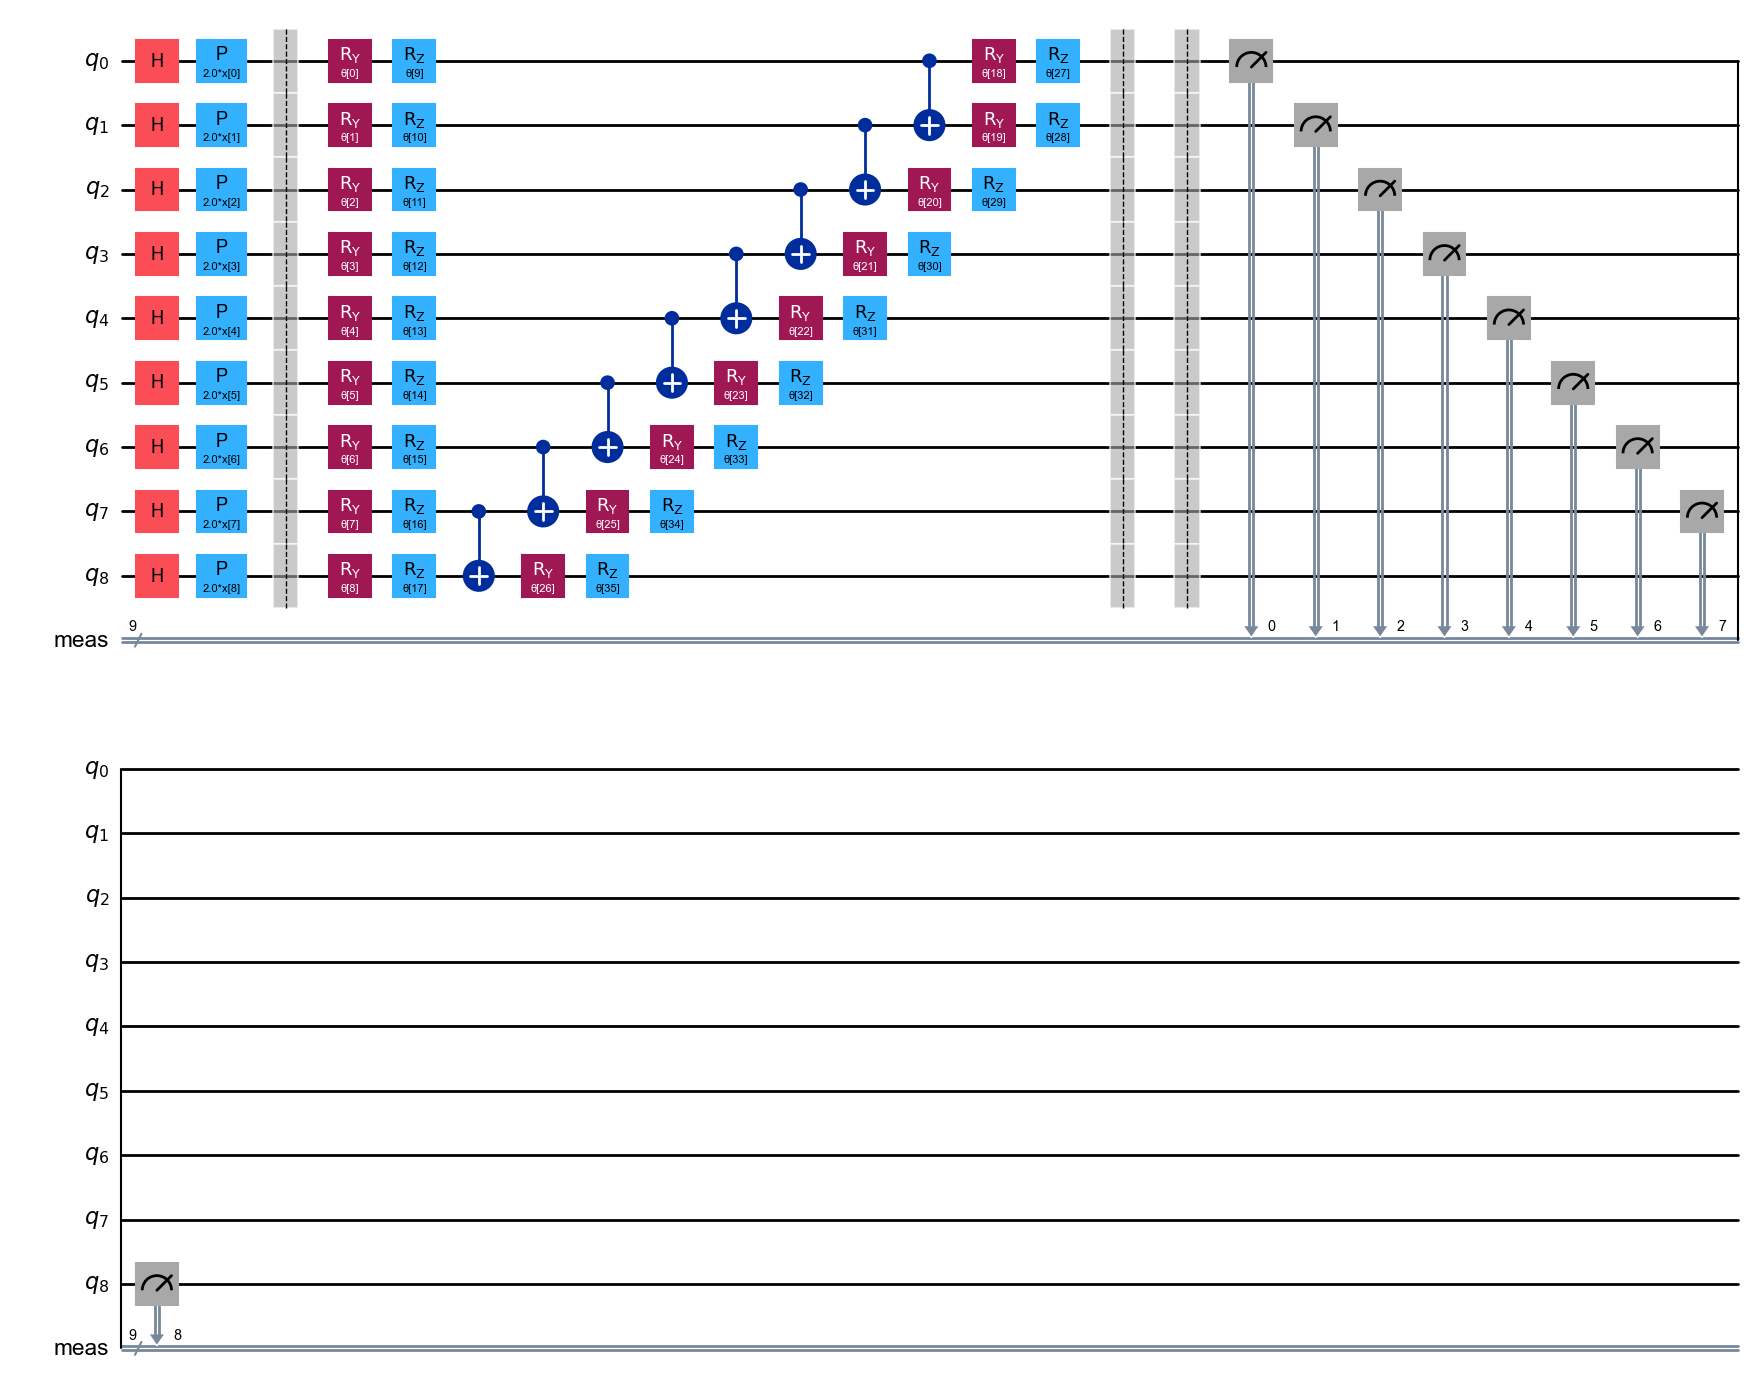

In [76]:
ad_hoc_circuit = feature_map.compose(ansatz)
ad_hoc_circuit.measure_all()
ad_hoc_circuit.decompose().draw(output="mpl", style="iqp")

### Funzioni di utilità per minimizzare la loss function

In [77]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

history = []


def init_history():
    history.clear()


objective_func_vals = []


def init_graph():
    plt.rcParams["figure.figsize"] = (12, 6)
    objective_func_vals = []
    clear_output(wait=True)


def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [78]:
from collections import Counter


def compute_class_weights(y_true):
    """
    Calcola pesi inversamente proporzionali alla frequenza di ciascuna classe.
    """
    counts = Counter(y_true)
    total = sum(counts.values())
    n_classes = len(counts)

    # Peso = totale / (n_classi * frequenza_classe)
    weights = {cls: total / (n_classes * freq) for cls, freq in counts.items()}
    return weights

def weighted_log_loss_with_class_balance(y_true, y_prob):
    """
    Log loss pesata in base all'inverso della frequenza di ciascuna classe.

    Parametri:
    - y_true: array (n,) delle etichette vere (interi)
    - y_prob: array (n, C) delle probabilità previste per ciascuna classe

    Ritorna:
    - log loss pesata
    """
    n_samples = len(y_true)
    n_classes = y_prob.shape[1]

    # One-hot encoding manuale
    y_true_oh = np.zeros_like(y_prob)
    y_true_oh[np.arange(n_samples), y_true] = 1

    # Calcola i pesi per classe
    class_weights = compute_class_weights(y_true)

    # Evita log(0)
    eps = 1e-15
    y_prob = np.clip(y_prob, eps, 1 - eps)

    # Calcolo log loss pesata
    log_losses = -np.sum(y_true_oh * np.log(y_prob), axis=1)
    weights = np.array([class_weights[cls] for cls in y_true])
    weighted_loss = np.average(log_losses, weights=weights)


    return float(weighted_loss)


In [79]:
#log_loss equivalente a cross-entropy
from sklearn.metrics import log_loss, accuracy_score
from qiskit.primitives import StatevectorSampler


def circuit_instance(tuple, variational):
    # tuple: una tupla
    # variational: parametri dell'ansatz (theta)
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] =tuple[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = variational[i]
    return ad_hoc_circuit.assign_parameters(parameters)


def interpreter(bitstring):
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight) % 3

def label_probability(results):
    shots = sum(results.values())
     #probabilities = {0: 0, 1: 0}
    probabilities = {0: 0, 1: 0, 2: 0}
    for bitstring, counts in results.items():
        label = interpreter(bitstring)
        probabilities[label] += counts / shots
    return probabilities

def classification_probability(data, variational):
    circuits = [circuit_instance(tupla, variational) for tupla in data]
    sampler = StatevectorSampler()
    results = sampler.run(circuits).result()
    classification = [
        label_probability(results[i].data.meas.get_counts()) for i, c in enumerate(circuits)]
    #print(classification)
    return classification


def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)

    #cost=log_loss(y_true=labels,y_pred=[[p[0],p[1],p[2]] for p in classifications])
    cost= weighted_log_loss_with_class_balance(labels,[[p[0],p[1],p[2]] for p in classifications])
    print(cost)
    history.append(cost)
    callback_graph(cost)
    print(cost)
    return cost


def objective_function(variational):
    return cost_function(X_train_new, y_train_new, variational)

In [81]:
import numpy as np
from scipy.optimize import minimize

init_history()
init_graph()
initial_point = np.zeros((ansatz.num_parameters))
res = minimize(objective_function, initial_point, method="cobyla", options={"maxiter": 500, "disp": True},)

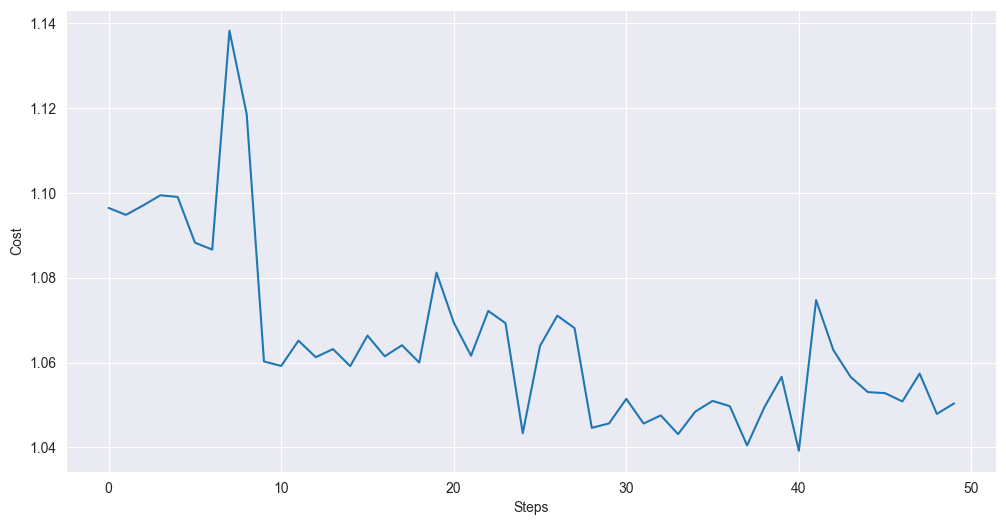

[ 1.01857534 -0.02542523 -0.05250083 -0.54362439  1.07429266  1.01862361
 -0.58571574 -0.29662188  1.29931045  1.01191727 -0.0676775  -0.02339343
 -0.04507831  1.00058224 -0.08178999 -0.02632467 -0.05597044 -0.0095923
 -0.25017807 -0.11664259 -0.02793262 -0.14784464 -0.11499765  1.17942662
 -0.23355661 -0.31459119 -0.2812112  -0.01427179 -0.02618506 -0.09191987
 -0.0259154  -0.04760626  1.00256851 -0.06047048 -0.08896434 -0.0749219 ]
1.039189791611618


In [19]:
opt_var = res.x # migliori parametri della funzione obiettivo e quindi dell'ansatz
opt_value = res.fun # ultima valutazione della funzione obiettivo, nel nostro caso cross-entropy (log_loss)

fig = plt.figure()
plt.plot(history)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print(opt_var)
print(opt_value)

In [20]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    #print(probability)
    predictions= [max(p, key=p.get) for p in probability]
    accuracy = 0
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy_train, predictions_train = test_classifier(X_train_new, y_train_new, opt_var)
accuracy_test, predictions_test = test_classifier(X_test_new, y_test_new, opt_var)
print(accuracy_train,accuracy_test)

0.5242290748898678 0.47959183673469385


In [21]:
from sklearn.metrics import balanced_accuracy_score

accuracy_train=balanced_accuracy_score(y_train_new,predictions_train)
accuracy_test=balanced_accuracy_score(y_test_new,predictions_test)
print(accuracy_train)
print(accuracy_test)

0.32782369146005513
0.3263888888888889


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_new,predictions_test)

array([[ 0,  0, 33],
       [ 0,  0, 17],
       [ 1,  0, 47]])

In [23]:
confusion_matrix(y_train_new,predictions_train)

array([[  0,   0,  70],
       [  0,   0,  36],
       [  2,   0, 119]])